In [1]:
import numpy as np
import cv2
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn.functional as F
import torch.nn as nn
import torch
import glob
import tqdm
import re
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')

In [2]:
def load_img_folder(img_dir):
    files = glob.glob(img_dir)
    data = []
    for f1 in files:
        data.append(f1)
    return data

def sort_input(datalist):
    pat=re.compile('\d')
    numlist = [i for i in pat.findall(datalist)][6:]
    num = sum([int(j)*10**int(i) for i,j in enumerate(numlist[:-1][::-1])])*10+int(numlist[-1])
    return num

def sort_test(datalist):
    pat=re.compile('\d')
    numlist = [i for i in pat.findall(datalist)][6:]
    num = sum([int(j)*10**int(i) for i,j in enumerate(numlist[:][::-1])])
    return num

In [3]:
input_data = load_img_folder("/home/f.yang1/CAP5404/Part2/L/*.jpg")
label_data_a = load_img_folder("/home/f.yang1/CAP5404/Part2/a/*.jpg")
label_data_b = load_img_folder("/home/f.yang1/CAP5404/Part2/b/*.jpg")
input_data = sorted(input_data, key = sort_input)
label_data_a = sorted(label_data_a, key = sort_input)
label_data_b = sorted(label_data_b, key = sort_input)

test_data = load_img_folder("/home/f.yang1/CAP5404/Part2/oriimge/*.jpg")
test_data = sorted(test_data, key = sort_test)[-75:]

In [4]:
class Train_Dataset(Dataset):
    def __init__(self):
        self.input_data = input_data[:-750]
        self.label_data_a = label_data_a[:-750]
        self.label_data_b = label_data_b[:-750]
        
    def __getitem__(self, index):
        X = cv2.imread(self.input_data[index],2)
        y1 = np.mean(cv2.imread(self.label_data_a[index],2))
        y2 = np.mean(cv2.imread(self.label_data_b[index],2))
        X = transforms.ToTensor()(X).cuda()
        y1 = torch.from_numpy(np.asarray(y1)).cuda()
        y2 = torch.from_numpy(np.asarray(y2)).cuda()
        
        y = torch.stack((y1,y2))
        return X, y

    def __len__(self):
        return len(self.input_data)
    

    
class Test_Dataset(Dataset):
    def __init__(self):
        self.dataset = test_data
        
    def __getitem__(self, index):
        img = cv2.imread(self.dataset[index])
        img = cv2.cvtColor(img,cv2.COLOR_BGR2LAB)
        L,a,b = cv2.split(img)
        y1 = np.mean(a)
        y2 = np.mean(b)
        X = transforms.ToTensor()(L).cuda()
        y1 = torch.from_numpy(np.asarray(y1)).cuda()
        y2 = torch.from_numpy(np.asarray(y2)).cuda()
        y = torch.stack((y1,y2))

        return X, y

    def __len__(self):
        return len(self.dataset)

In [5]:
# train input [batch size,128,128] label [batch size, 2]
Train_data = Train_Dataset()
Train_Dataloader = DataLoader(Train_data,batch_size=512,shuffle = True,drop_last=True)

# test input [batch size, 128, 128] label [batch size, 2]
Test_data = Test_Dataset()
Test_Dataloader = DataLoader(Test_data,batch_size=75,shuffle = True)

In [6]:
class FCN(torch.nn.Module):
    def __init__(self):
        super(FCN, self).__init__()
        self.l1 = torch.nn.Linear(16384, 4096)
        self.l2 = torch.nn.Linear(4096, 1024)
        self.l3 = torch.nn.Linear(1024, 512)
        self.l4 = torch.nn.Linear(512, 256)
        self.l5 = torch.nn.Linear(256, 2)
 
    def forward(self, x):
        x = x.view(-1, 16384)
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = F.relu(self.l3(x))
        x = F.relu(self.l4(x))
        return self.l5(x)
 
net = FCN().cuda()

In [7]:
# for X,y in Test_Dataloader:
#     print(X.shape)
#     print(y.shape)

In [8]:
loss = nn.SmoothL1Loss().cuda()
trainer = torch.optim.Adam(net.parameters(), lr=0.0001)
num_epochs = 20
loss_item = []
for epoch in tqdm.tqdm(range(num_epochs)):
    for X,y in Train_Dataloader:
        l = loss(net(X.float()) ,y)
#         print(y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
        loss_item.append(l.cpu().item())


100%|██████████| 20/20 [05:52<00:00, 17.64s/it]


Text(0.5, 1.0, 'FCN')

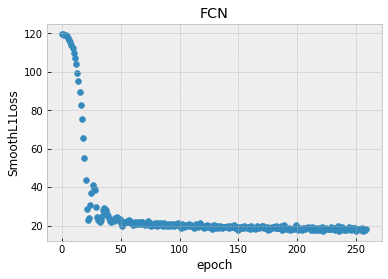

In [9]:
len(loss_item)
x = [i for i in range(260)]
plt.scatter(x,loss_item)
plt.xlabel("epoch")
plt.ylabel("SmoothL1Loss")
plt.title("FCN")

In [10]:
net.eval()
test_loss = nn.MSELoss().cuda()
for X,y in Test_Dataloader:
    with torch.no_grad(): 
        output = net(X.float()) 
    MSE = test_loss(y,output).item()/75
print("FCN: on the test dataset MSE = {}".format(MSE))

FCN: on the test dataset MSE = 12.125846295169508


In [37]:
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 4, (4,4), stride=2,padding=1),
            nn.ReLU(),
            nn.Conv2d(4, 8, (4,4), stride=2,padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 16, (4,4), stride=2,padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 8, (4,4), stride=2,padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 4, (4,4), stride=2,padding=1),
            nn.ReLU(),
            nn.Conv2d(4, 2, (4,4), stride=2,padding=1),
            nn.ReLU(),
            nn.Conv2d(2, 2, (4,4), stride=2,padding=1),
        )
 
    def forward(self, x):
        return self.conv1(x)
    
def init_weights(layer):

    if type(layer) == nn.Conv2d:
        nn.init.normal_(layer.weight, mean=0, std=0.5)
        
net = CNN().cuda()
net.apply(init_weights)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 4, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(4, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(8, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(16, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(8, 4, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(4, 2, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(2, 2, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
)

In [38]:
loss = nn.SmoothL1Loss().cuda()
trainer = torch.optim.Adam(net.parameters(), lr=0.001)
num_epochs = 20
loss_item = []
for epoch in tqdm.tqdm(range(num_epochs)):
    for X,y in Train_Dataloader:
        l = loss(net(X) ,y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
        loss_item.append(l.cpu().item())
#     print(l)

100%|██████████| 20/20 [05:30<00:00, 16.52s/it]


Text(0.5, 1.0, 'CNN')

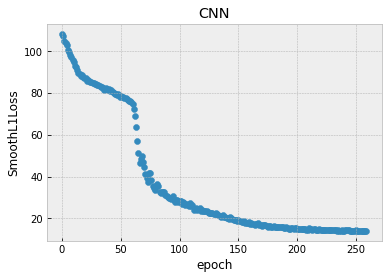

In [39]:
len(loss_item)
x = [i for i in range(260)]
plt.scatter(x,loss_item)
plt.xlabel("epoch")
plt.ylabel("SmoothL1Loss")
plt.title("CNN")

In [44]:
net.eval()
test_loss = nn.MSELoss().cuda()
for X,y in Test_Dataloader:
    with torch.no_grad(): 
        output = net(X.float()) 
    MSE = test_loss(y,output).item()/75
print("CNN: on the test dataset MSE = {}".format(MSE))

CNN: on the test dataset MSE = 8.56694995502701
